<a href="https://colab.research.google.com/github/msamir-dls/PEFT_LoRA_QLoRA/blob/main/Complete_LoRA_Finetune_llama3_8b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Environment Setup & Dependencies
In this section, we install the necessary libraries for efficient LLM fine-tuning.



*   bitsandbytes: Enables 4-bit quantization, allowing us to load massive models (like Llama-3 8B) into GPU memory by compressing weights.
*   peft (Parameter-Efficient Fine-Tuning): Instead of training the entire model (which is expensive), we use LoRA (Low-Rank Adaptation) to train only a tiny fraction of parameters.
*   trl (Transformer Reinforcement Learning): Provides the SFTTrainer, a wrapper optimized for Supervised Fine-Tuning of LLMs.
*   accelerate: Handles hardware optimization, distributing computations efficiently across the GPU.

# Mathematical Foundation: Quantization (NF4)
We use bitsandbytes to load the model in 4-bit NormalFloat (NF4). Unlike standard linear quantization, NF4 is information-theoretically optimal for weights that follow a normal distribution (which most LLM weights do).The quantization maps a high-precision weight $W$ to a discrete 4-bit value $q$. The quantization levels $q_i$ are determined by the quantiles of the Standard Normal Distribution $N(0,1)$:$$q_i = Q^{-1}\left(\frac{i}{2^k + 1}\right)$$Where:$Q^{-1}$ is the inverse Cumulative Distribution Function (CDF) of the Normal distribution.$k$ is the number of bits (here $k=4$, yielding 16 distinct levels).This ensures that the limited 4-bit "bins" are concentrated where the majority of the weight values actually exist (near zero), minimizing the Quantization Error

($Error = ||W - \text{dequant}(W_{q})||^2$).
















In [1]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets einops wandb bitsandbytes matplotlib

# Check GPU status
import torch
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    # A100 Optimization Check
    if torch.cuda.get_device_capability()[0] >= 8:
        print(" A100/H100/RTX3090+ Detected: Flash Attention 2 & BFloat16 enabled.")
    else:
        print(" Legacy GPU Detected: Fallback to FP16.")
else:
    print(" No GPU detected.")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
PyTorch version: 2.9.0+cu128
CUDA device: NVIDIA A100-SXM4-40GB
GPU Memory: 42.41 GB
 A100/H100/RTX3090+ Detected: Flash Attention 2 & BFloat16 enabled.


# 2. Configuration & Architecture
We use a Configuration Class (TrainingConfig). This acts as a central control panel for hyperparameters.

Key Decisions for A100 vs. T4:

* Precision (bf16 vs fp16): On an A100, we strictly use bf16 (Brain Float 16). It has the same dynamic range as Float32, preventing "NaN" (Not a Number) errors during training without needing a gradient scaler. On a T4, we would rely on fp16.

* Attn Implementation: We enable flash_attention_2. This is a hardware-aware algorithm that speeds up the Attention mechanism by ~3x on A100 GPUs.

# Mathematical Foundation: Precision & Dynamic Range

We select BFloat16 (bf16) over Float16 (fp16) for the A100.Float32 (Standard): 1 Sign bit, 8 Exponent bits, 23 Mantissa bits.Float16 (Legacy): 1 Sign bit, 5 Exponent bits, 10 Mantissa bits. Narrow dynamic range leads to underflow (gradients becoming 0).BFloat16 (Brain Float): 1 Sign bit, 8 Exponent bits, 7 Mantissa bits.$$\text{Range}(BF16) \approx \text{Range}(FP32)$$Because BFloat16 preserves the 8-bit exponent of FP32, it prevents numerical instability during training without requiring specific gradient scaling techniques.

In [2]:
import os
import torch
import time
import psutil
import matplotlib.pyplot as plt
from dataclasses import dataclass
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging
)
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer, SFTConfig

# Centralized Configuration
@dataclass
class TrainingConfig:
    model_name: str = "meta-llama/Meta-Llama-3-8B-Instruct"
    dataset_name: str = "timdettmers/openassistant-guanaco"
    new_model_name: str = "Llama-3-8B-Instruct-Guanaco-Adapter"

    # QLoRA Parameters
    lora_r: int = 64              # Rank: Higher = more parameters to train, smarter but slower
    lora_alpha: int = 128          # Scaling factor
    lora_dropout: float = 0.05

    # Training Parameters
    batch_size: int = 2            # Per device batch size
    grad_accum_steps: int = 4      # Accumulate gradients to simulate larger batch size
    num_epochs: int = 1            # Total epochs (for 1 epoch ~ 2 Hrs)
    learning_rate: float = 2e-4
    max_seq_length: int = 2048     # Llama-3 supports up to 8k, but 2048 is standard for fine-tuning

    # Hardware Optimization (A100 Specifics)
    use_4bit: bool = True          # Activate QLoRA
    bnb_4bit_compute_dtype: str = "bfloat16" # computation type
    use_nested_quant: bool = True

    # Output
    output_dir: str = "./results"

config = TrainingConfig()

# 3. The LLMFineTuner Engine
We encapsulate the entire lifecycle in a Python Class. This abstraction allows us to initialize, train, and inference with single commands.

Concepts Used:

* Gradient Checkpointing: This technique saves VRAM by not storing all intermediate activations during the forward pass. Instead, it recomputes them during the backward pass. It trades a small amount of compute for massive memory savings.

* QLoRA (Quantized LoRA): We load the base model in 4-bit (lossy compression) but perform the training calculations in 16-bit. This allows us to finetune a 16GB model on a card with less memory, though A100 handles this easily.

* Tokenizer Padding: Llama-3 does not have a native PAD token. We set pad_token = eos_token to ensure batches are processed correctly.

# Mathematical Foundation: Low-Rank Adaptation (LoRA)

Fine-tuning a full model requires updating all parameters $W$. LoRA freezes the pre-trained weights $W_0$ and injects trainable rank decomposition matrices $A$ and $B$.For a layer with input $x$, the forward pass becomes:$$h = W_0 x + \Delta W x = W_0 x + \frac{\alpha}{r} (B A) x$$Where:$W_0 \in \mathbb{R}^{d \times k}$: Frozen pre-trained weights.$B \in \mathbb{R}^{d \times r}$ and $A \in \mathbb{R}^{r \times k}$: Trainable adapter matrices.$r \ll \min(d, k)$: The rank (e.g., $r=64$).$\alpha$: A scaling constant to control signal strength.This reduces the number of trainable parameters by a factor of roughly $r/d$. For Llama-3, this reduces trainable parameters from 8 Billion to roughly 160 Million (~2%), massively reducing VRAM requirements while maintaining performance.Optimization: Flash Attention 2Standard attention computes an $N \times N$ matrix ($S = QK^T$), leading to $O(N^2)$ memory complexity. Flash Attention tiles the computation to keep data in the GPU's fast SRAM, avoiding slow HBM (High Bandwidth Memory) reads/writes.$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_{head}}}\right)V$$While the formula is identical, Flash Attention computes this block-wise, achieving near-linear IO complexity with respect to sequence length.

In [6]:
# run this to install flash attention one time, then restart the session.

!pip uninstall -y flash-attn
!pip install -q ninja packaging
!pip install -q flash-attn --no-build-isolation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 59.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import flash_attn
print("FlashAttention installed")

FlashAttention installed


In [4]:
class LLMFineTuner:
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.model = None
        self.tokenizer = None
        self.trainer = None
        self.device_map = "auto"

    def load_model_and_tokenizer(self):
        print(f" Loading Base Model: {self.config.model_name}...")

        # 1. BitsAndBytes Config (Quantization)
        compute_dtype = getattr(torch, self.config.bnb_4bit_compute_dtype)
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=self.config.use_4bit,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=compute_dtype,
            bnb_4bit_use_double_quant=self.config.use_nested_quant,
        )

        # 2. Load Base Model
        # A100 OPTIMIZATION: attn_implementation="flash_attention_2"
        self.model = AutoModelForCausalLM.from_pretrained(
            self.config.model_name,
            quantization_config=bnb_config,
            device_map=self.device_map,
            torch_dtype=compute_dtype,
            attn_implementation="flash_attention_2"
        )

        self.model = prepare_model_for_kbit_training(self.model)
        self.model.gradient_checkpointing_enable()

        # Disable cache for training (reduces VRAM)
        self.model.config.use_cache = False
        self.model.config.pretraining_tp = 1

        # 3. Load Tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.config.model_name, trust_remote_code=True)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.tokenizer.padding_side = "right"

        print(" Model and Tokenizer Loaded Successfully.")

    def configure_lora(self):
        # Target modules for Llama-3 (All linear layers for best performance)
        peft_config = LoraConfig(
            lora_alpha=self.config.lora_alpha,
            lora_dropout=self.config.lora_dropout,
            r=self.config.lora_r,
            bias="none",
            task_type="CAUSAL_LM",
            target_modules=['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']
        )
        return peft_config

    def train(self):
        if not self.model:
            self.load_model_and_tokenizer()

        dataset = load_dataset(self.config.dataset_name, split="train")
        def preprocess(example):
          return self.tokenizer(
              example["text"],
              truncation=True,
              max_length=self.config.max_seq_length
              )

        dataset = dataset.map(preprocess, batched=True, remove_columns=dataset.column_names)
        peft_config = self.configure_lora()

        training_arguments = SFTConfig(
            output_dir=self.config.output_dir,
            num_train_epochs=self.config.num_epochs,
            per_device_train_batch_size=self.config.batch_size,
            gradient_accumulation_steps=self.config.grad_accum_steps,
            optim="paged_adamw_8bit",
            save_steps=50,
            save_total_limit=3, # will only save newest 4 checkpoints and delete the older ones to save disk space
            logging_steps=10,
            learning_rate=self.config.learning_rate,
            weight_decay=0.001,
            fp16=False,
            bf16=True, # A100 supports BFloat16 natively
            max_grad_norm=0.3,
            # max_seq_length=self.config.max_seq_length,
            warmup_ratio=0.03,
            group_by_length=True,
            lr_scheduler_type="cosine",
            report_to="none",
            dataset_text_field="text"
        )

        self.trainer = SFTTrainer(
            model=self.model,
            train_dataset=dataset,
            peft_config=peft_config,
            processing_class=self.tokenizer,
            args=training_arguments
        )

        # Fix for norm layers in quantized models
        for name, module in self.trainer.model.named_modules():
             if "norm" in name:
                 module.to(torch.float32)

        print(" Starting Training...")
        start_time = time.time()
        self.trainer.train()
        end_time = time.time()

        training_time = end_time - start_time
        print(f" Training Complete in {training_time/60:.2f} minutes.")

        # Save Model
        self.trainer.model.save_pretrained(self.config.new_model_name)
        self.tokenizer.save_pretrained(self.config.new_model_name)

        return self.trainer

    @torch.inference_mode()
    def generate_response(self, prompt, max_new_tokens=200):
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

        outputs = self.model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.1,
        )

        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

# 4. Execution Pipeline
We now instantiate our LLMFineTuner and start the process.

Resource Monitoring: We use psutil and PyTorch commands to track VRAM usage. Note on Epochs: We set num_epochs=1. For large datasets like Guanaco (9k samples), 1 epoch is often sufficient for the model to learn the style without overfitting (forgetting its general knowledge).

# Mathematical Foundation: Gradient Accumulation

Since LLMs are large, we cannot fit a large batch size $B$ into memory. We simulate a large batch size using Gradient Accumulation. We compute gradients for smaller micro-batches and sum them up before performing a weight update.$$B_{effective} = B_{micro} \times N_{accum} \times N_{GPUs}$$The weight update rule (SGD example) happens only after $N_{accum}$ steps:$$W_{t+1} = W_t - \eta \frac{1}{B_{effective}} \sum_{i=1}^{B_{effective}} \nabla \mathcal{L}(x_i, y_i)$$This allows us to mathematically simulate a large batch size (stable training) while physically only holding a small batch in VRAM.

In [5]:
# Login to HuggingFace (Required for Llama-3)
from huggingface_hub import notebook_login
notebook_login()

# Initialize the Engine
tuner = LLMFineTuner(config)

# Track Memory Before
torch.cuda.empty_cache()
gpu_stats_before = torch.cuda.memory_allocated() / 1024**3
print(f"Initial GPU Memory: {gpu_stats_before:.2f} GB")

# Start Training
trainer_instance = tuner.train()

# Track Memory After
gpu_stats_after = torch.cuda.memory_allocated() / 1024**3
print(f"Peak GPU Memory: {gpu_stats_after:.2f} GB")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Initial GPU Memory: 0.00 GB
 Loading Base Model: meta-llama/Meta-Llama-3-8B-Instruct...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

 Model and Tokenizer Loaded Successfully.


README.md:   0%|          | 0.00/395 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


openassistant_best_replies_train.jsonl:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

openassistant_best_replies_eval.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9846 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/9846 [00:00<?, ? examples/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Truncating train dataset:   0%|          | 0/9846 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128009}.


 Starting Training...


Casting fp32 inputs back to torch.bfloat16 for flash-attn compatibility.


Step,Training Loss
10,1.399261
20,1.217766
30,1.400366
40,1.512179
50,1.676867
60,1.192474
70,1.243977
80,1.275320
90,1.580824
100,1.687641


 Training Complete in 65.25 minutes.
Peak GPU Memory: 7.62 GB


# 5. Training Metrics Visualization
Analyzing the Loss Curve is crucial.

* Loss: Represents the error. It should decrease over time.

* Overfitting: If Training Loss goes down but Validation Loss goes up (or stays flat), the model is memorizing data rather than learning patterns.

* We extract the logs from the trainer history to visualize this.

# Mathematical Foundation: Cross-Entropy Loss

The model is trained to predict the next token $u_t$ given the history $u_{<t}$. We minimize the negative log-likelihood over the dataset $D$:$$\mathcal{loss}(\theta) = -\sum_{(u) \in D} \sum_{t=1}^{T} \log P(u_t | u_{<t}; \theta)$$Loss Decrease: Indicates the model is assigning higher probability to the correct next tokens.Perplexity (PPL): A common metric derived from loss: $PPL = e^{\mathcal{loss}}$. Lower is better.

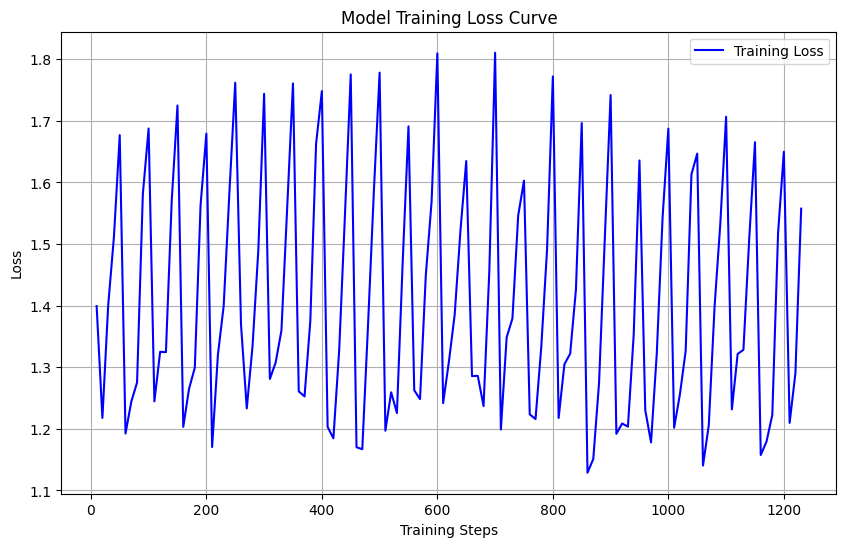

In [6]:
def plot_training_history(trainer):
    log_history = trainer.state.log_history

    steps = []
    losses = []

    for log in log_history:
        if "loss" in log:
            steps.append(log["step"])
            losses.append(log["loss"])

    plt.figure(figsize=(10, 6))
    plt.plot(steps, losses, label="Training Loss", color="blue")
    plt.title("Model Training Loss Curve")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize
plot_training_history(trainer_instance)

# 6. Inference (Testing the Model)
Now that the model is trained, we must test it. Note that we are using the Adapter (LoRA weights) combined with the Base Model.

* Temperature: Controls randomness. Low (0.1) is factual/robotic. High (1.0) is creative/chaotic. We use 0.7 for a balance.

In [7]:
# Clean memory for inference
torch.cuda.empty_cache()

user_prompt = "Human: What are the main differences between Python and C++? Assistant:"

print("generating response...")
response = tuner.generate_response(user_prompt)

print("-" * 50)
print("FINAL GENERATED OUTPUT:")
print("-" * 50)
print(response)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
Caching is incompatible with gradient checkpointing in LlamaDecoderLayer. Setting `past_key_values=None`.


generating response...
--------------------------------------------------
FINAL GENERATED OUTPUT:
--------------------------------------------------
Human: What are the main differences between Python and C++? Assistant: Python president### Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã Ã


If you use this on a T4 GPU, make these changes in TrainingConfig:

* bf16 = False, fp16 = True (T4 doesn't support BFloat16).

* bnb_4bit_compute_dtype = "float16".

* Remove attn_implementation="flash_attention_2" (T4 doesn't support Flash Attention 2).

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
